# POC: Acceleration Estimation Smoothing with Multiple Exogenous Noise Sources and Long Term Drift

In [6]:
import numpy as np
import matplotlib.pyplot as plt

## Harmonic Oscillator Synthetic Data

In [34]:
# Example usage
AMPLITUDE = 1.0
FREQUENCY = 2.0
DAMPING_FACTOR = 0.1
TIME_START = 0.0
TIME_END = 10.0
NUM_SAMPLES = 1000


#RNN and LSTM parameters
SEQUENCE_LENGTH = 128

In [35]:
def generate(noise_std=0.0):
    time = np.linspace(TIME_START, TIME_END, NUM_SAMPLES)
    angular_frequency = 2 * np.pi * FREQUENCY
    exponential_decay = np.exp(-DAMPING_FACTOR * time)
    oscillation = AMPLITUDE * np.cos(angular_frequency * time)
    if noise_std > 0.0:
        noise = np.random.normal(0, noise_std, NUM_SAMPLES)
        data = oscillation * exponential_decay + noise
    else:
        data = oscillation * exponential_decay

    return time, data

# Run the simulation
time, positions = generate(0.1)
time, ground_truth= generate()

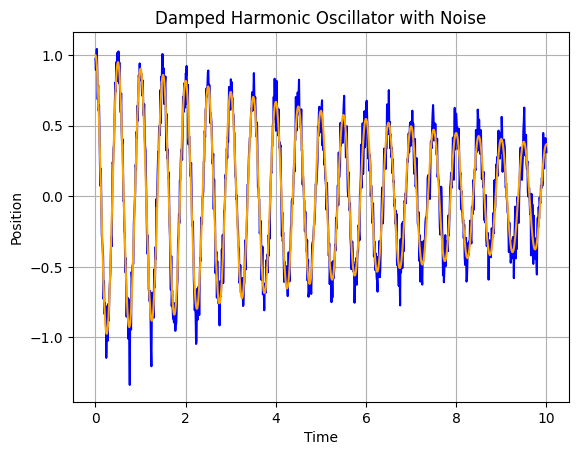

In [36]:
# Plot the results
plt.plot(time, positions, color='blue', label='Noisy')
plt.plot(time, ground_truth, color='orange', label='Ground Truth')
plt.xlabel('Time')
plt.ylabel('Position')
plt.title('Damped Harmonic Oscillator with Noise')
plt.grid(True)
plt.show()

## Kalman Filter

In [44]:
from filterpy.kalman import KalmanFilter
import numpy as np

kf = KalmanFilter(dim_x=1, dim_z=1)

# state transition matrix
kf.F = np.array([[1.]])

# measurement function matrix
kf.H = np.array([[1.]])

# covariance matrix // process noise
kf.Q = np.array([[0.1]])

# covariance matrix // measurement noise 
kf.R = np.array([[1.]])

# initialize state
kf.x = np.array([[0.]])

# initialize covariance matrix 
kf.P = np.array([[1.]])

# Perform the filtering
filtered_positions = []
for position in positions:
    kf.predict()
    kf.update(position)
    filtered_positions.append(kf.x[0, 0 ])

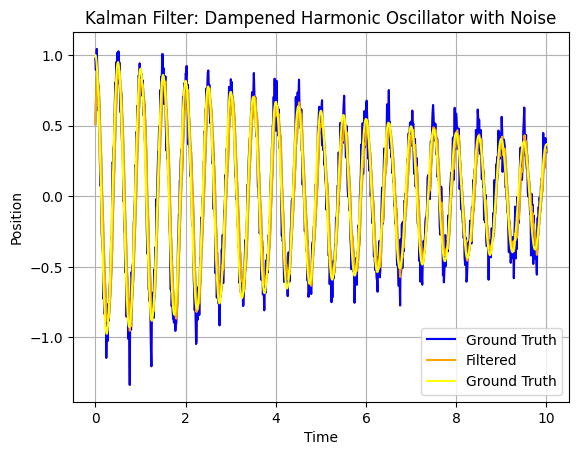

In [46]:
plt.plot(time, filtered_positions)
plt.plot(time, positions)

# Plot the lines with labels
plt.plot(time, positions, color='blue', label='Ground Truth')
plt.plot(time, filtered_positions, color='orange', label='Filtered')
plt.plot(time, ground_truth, color='yellow', label='Ground Truth')


# Add legend
plt.legend()

plt.xlabel('Time')
plt.ylabel('Position')
plt.title('Kalman Filter: Dampened Harmonic Oscillator with Noise')
plt.grid(True)
plt.show()

In [49]:
criterion(torch.tensor(filtered_positions, dtype=torch.float32), torch.tensor(ground_truth, dtype=torch.float32))

tensor(0.0236)

In [26]:
import torch
import torch.nn as nn

# Define the LSTM Autoencoder
class LSTMAutoencoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(LSTMAutoencoder, self).__init__()
        self.encoder = nn.LSTM(input_size, hidden_size, num_layers, batch_first=False)
        self.decoder = nn.LSTM(hidden_size, input_size, num_layers, batch_first=False)

    def forward(self, x):
        _, (hidden, _) = self.encoder(x)
        output, _ = self.decoder(hidden)
        return output

# Define the RNN Autoencoder
class RNNAutoencoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(RNNAutoencoder, self).__init__()
        self.encoder = nn.RNN(input_size, hidden_size, num_layers, batch_first=False)
        self.decoder = nn.RNN(hidden_size, input_size, num_layers, batch_first=False)

    def forward(self, x):
        _, hidden = self.encoder(x)
        output, _ = self.decoder(hidden)
        return output

# Instantiate the LSTM Autoencoder
input_size = 1
hidden_size = 32
num_layers = 2
lstm_autoencoder = LSTMAutoencoder(input_size, hidden_size, num_layers)

# Instantiate the RNN Autoencoder
rnn_autoencoder = RNNAutoencoder(input_size, hidden_size, num_layers)

# Define the loss function
criterion = nn.MSELoss()

In [30]:
positions = torch.tensor(positions, dtype = torch.float32)

/var/folders/kx/bhf1mlzs5kbf5snwtjjz60gc0000gn/T/ipykernel_14456/2024024351.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  positions = torch.tensor(positions, dtype = torch.float32)


# RNN 

In [32]:
# Pass the data through the RNN Autoencoder
rnn_output = rnn_autoencoder(positions)
rnn_loss = criterion(rnn_output[0], torch.tensor(ground_truth, dtype=torch.float32))
print("RNN Autoencoder Loss:", rnn_loss.item())

RNN Autoencoder Loss: 0.7393873929977417


/Users/laurenmoos/miniconda3/envs/torch/lib/python3.8/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1000])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


# LSTM

In [33]:
# Pass the data through the LSTM Autoencoder
lstm_output = lstm_autoencoder(positions)

# Calculate the reconstruction loss
lstm_loss = criterion(lstm_output[0], torch.tensor(ground_truth, dtype=torch.float32))

# Print the reconstruction loss
print("LSTM Autoencoder Loss:", lstm_loss.item())

LSTM Autoencoder Loss: 0.30511239171028137
